# Spark Streaming

Spark Streaming is an extension of the core Spark API that enables scalable, high-throughput, fault-tolerant stream processing of live data streams. Data can be ingested from many sources like Kafka, Flume, Kinesis, or TCP sockets, and can be processed using complex algorithms expressed with high-level functions like map, reduce, join and window. Finally, processed data can be pushed out to filesystems, databases, and live dashboards. 

To stream data via Twitter:
1. Create a Twitter Developer Account
2. Write a script to connect to Twitter for streaming (a TweetRead.py file)
3. Set a jupyter notebook with spark to connect to the socket connection via TweetRead.py  

In [1]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

In [2]:
# Can only run this once. restart your kernel for any errors.
sc = SparkContext()

In [3]:
ssc = StreamingContext(sc, 10 )
sqlContext = SQLContext(sc)

In [4]:
socket_stream = ssc.socketTextStream("127.0.0.1", 9998)

In [5]:
lines = socket_stream.window( 20 )

In [6]:
from collections import namedtuple
# namedTuple is a tuple where each element is assigned a name
# main idea is to do a count of the hashtags of the tweets
fields = ("tag", "count" )
Tweet = namedtuple( 'Tweet', fields )

Next we will: 
1. Grab the line (the tweet) and split it on whitespace to get a list of words
2. Use .filter() that will filter out things based on a condition. The condition being every word in the list is converted to lowercase and filtered if it starts with a hashtag.
3. Lowercase each word and add it to a tuple like (word.lower(), 1), where 1 is always the second parameter in the tuple
4. Reduce or group by key to get a word count of the hashtags
5. Store it into a Tweet object (a namedtuple with (tag,count)) so that we can plot it
6. For each RDD, convert RDD to DataFrame and sort it in the descending order by count 
7. Limit the count to top 10 tweets and save it to a temporary table

In [7]:
# Use Parenthesis for multiple lines or use \.
( lines.flatMap( lambda text: text.split( " " ) ) #Splits the line to a list of words
  .filter( lambda word: word.lower().startswith("#") ) # Checks for hashtag calls
  .map( lambda word: ( word.lower(), 1 ) ) # Lower cases the word
  .reduceByKey( lambda a, b: a + b ) # Reduces
  .map( lambda rec: Tweet( rec[0], rec[1] ) ) # Stores in a Tweet Object
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") ) # Sorts Them in a DF
  .limit(10).registerTempTable("tweets") ) ) # Registers to a table.

__________
### Run TweetRead.py
__________

In [8]:
ssc.start()    

In [9]:
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
# Only works for Jupyter Notebooks!
%matplotlib inline 

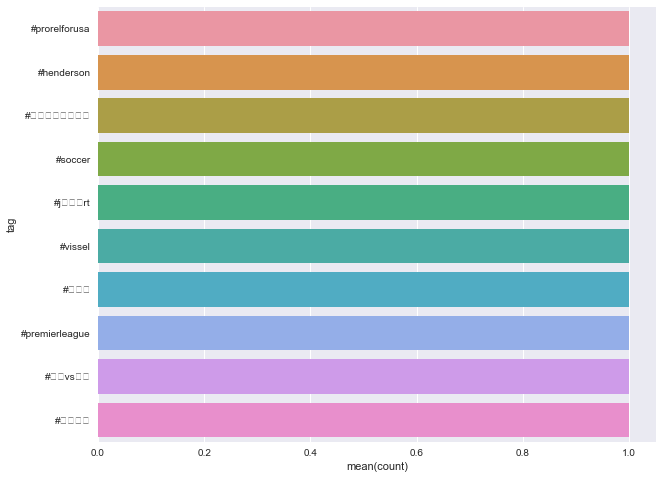

In [10]:
count = 0
while count < 10:
    
    time.sleep( 3 )
    top_10_tweets = sqlContext.sql( 'Select tag, count from tweets' )
    top_10_df = top_10_tweets.toPandas()
    display.clear_output(wait=True)
    sns.plt.figure( figsize = ( 10, 8 ) )
    sns.barplot( x="count", y="tag", data=top_10_df)
    sns.plt.show()
    count = count + 1

In [11]:
ssc.stop()

----------------------------------------